In [18]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [19]:
old_color_map = {
    'Commercial': '#de001e',
    'Industrial': '#bdeff2',
    'Transit Oriented Development': '#aa66cd',
    'Office': '#f2aa0f',
    'High Density Residential': '#8a4f36',
    'Medium Density Residential': '#d1b89b',
    'Low Density Residential': '#fcf8cc',
    'Institutions': '#c1f5bf',
    'Park/Open Space': '#0c752f',
    "Office/Multi-Family": "#f2cbb8",
    "Greenbelt/Urban Separator": "#00c5ff",
}
new_color_map = {
    "Transit Oriented Development": "#8401a9",
    "Center Mixed Use": "#c500ff",
    "Community Mixed Use": "#ffaa01",
    "Residential Mixed Use": "#ffffcf",
    "Industrial Mixed Use": "#ccdcfe",
    "Public/Civic/Institution": "#c7e6ba",
    "Park/Open Space": "#87ce30",
    "Greenbelt/Urban Separator": "#5c8944",
}
possible_category_mapping = {
    "Commercial": "Center Mixed Use",
    "Industrial": "Industrial Mixed Use",
    "Transit Oriented Development": "Transit Oriented Development",
    "Office": "Community Mixed Use",
    "High Density Residential": "Community Mixed Use",
    "Medium Density Residential": "Community Mixed Use",
    "Low Density Residential": "Residential Mixed Use",
    "Institutions": "Public/Civic/Institution",
    "Park/Open Space": "Park/Open Space",
    "Office/Multi-Family": "Community Mixed Use",
    "Greenbelt/Urban Separator": "Greenbelt/Urban Separator",
}
index_cat_mapping = {
    60: "Transit Oriented Development",
    296: "Transit Oriented Development",
    290: "Transit Oriented Development",
    64: "Transit Oriented Development",
    291: "Center Mixed Use",
    344: "Center Mixed Use",
    # 125: "Transit Oriented Development",
    
    133: "Community Mixed Use",
    # 101: "Residential Mixed Use",
    # 108: "Residential Mixed Use",
}

In [20]:
gdf = gpd.read_file("data/PL_Complan.zip").to_crs("EPSG:2285").reset_index()
#this file is old and doesn't account for the Houghton Park and Ride already being set to Transit Oriented Development and also doesn't account for the Fisk property being set to Park/Open Space
# gdf["COMP_DESN"] = gdf.apply(lambda r: "Transit Oriented Development" if r["index"] == 125 else r["COMP_DESN"], axis=1) #for correcting the old map if have to the current land use map
gdf["area_acres"] = gdf.area / 43560
gdf = gdf.to_crs("EPSG:3857")

In [21]:
gdf["color"] = gdf["COMP_DESN"].apply(lambda cd: old_color_map[cd])
gdf["possible_new_category"] = gdf.apply(
    lambda r: 
        possible_category_mapping[r["COMP_DESN"]] if r["index"] not in index_cat_mapping
        else index_cat_mapping[r["index"]],
    axis=1
)
gdf["possible_new_color"] = gdf["possible_new_category"].apply(lambda pnc: new_color_map[pnc])

(-13610767.166407846, -13596968.58979357, 6046749.440158415, 6064651.080911842)

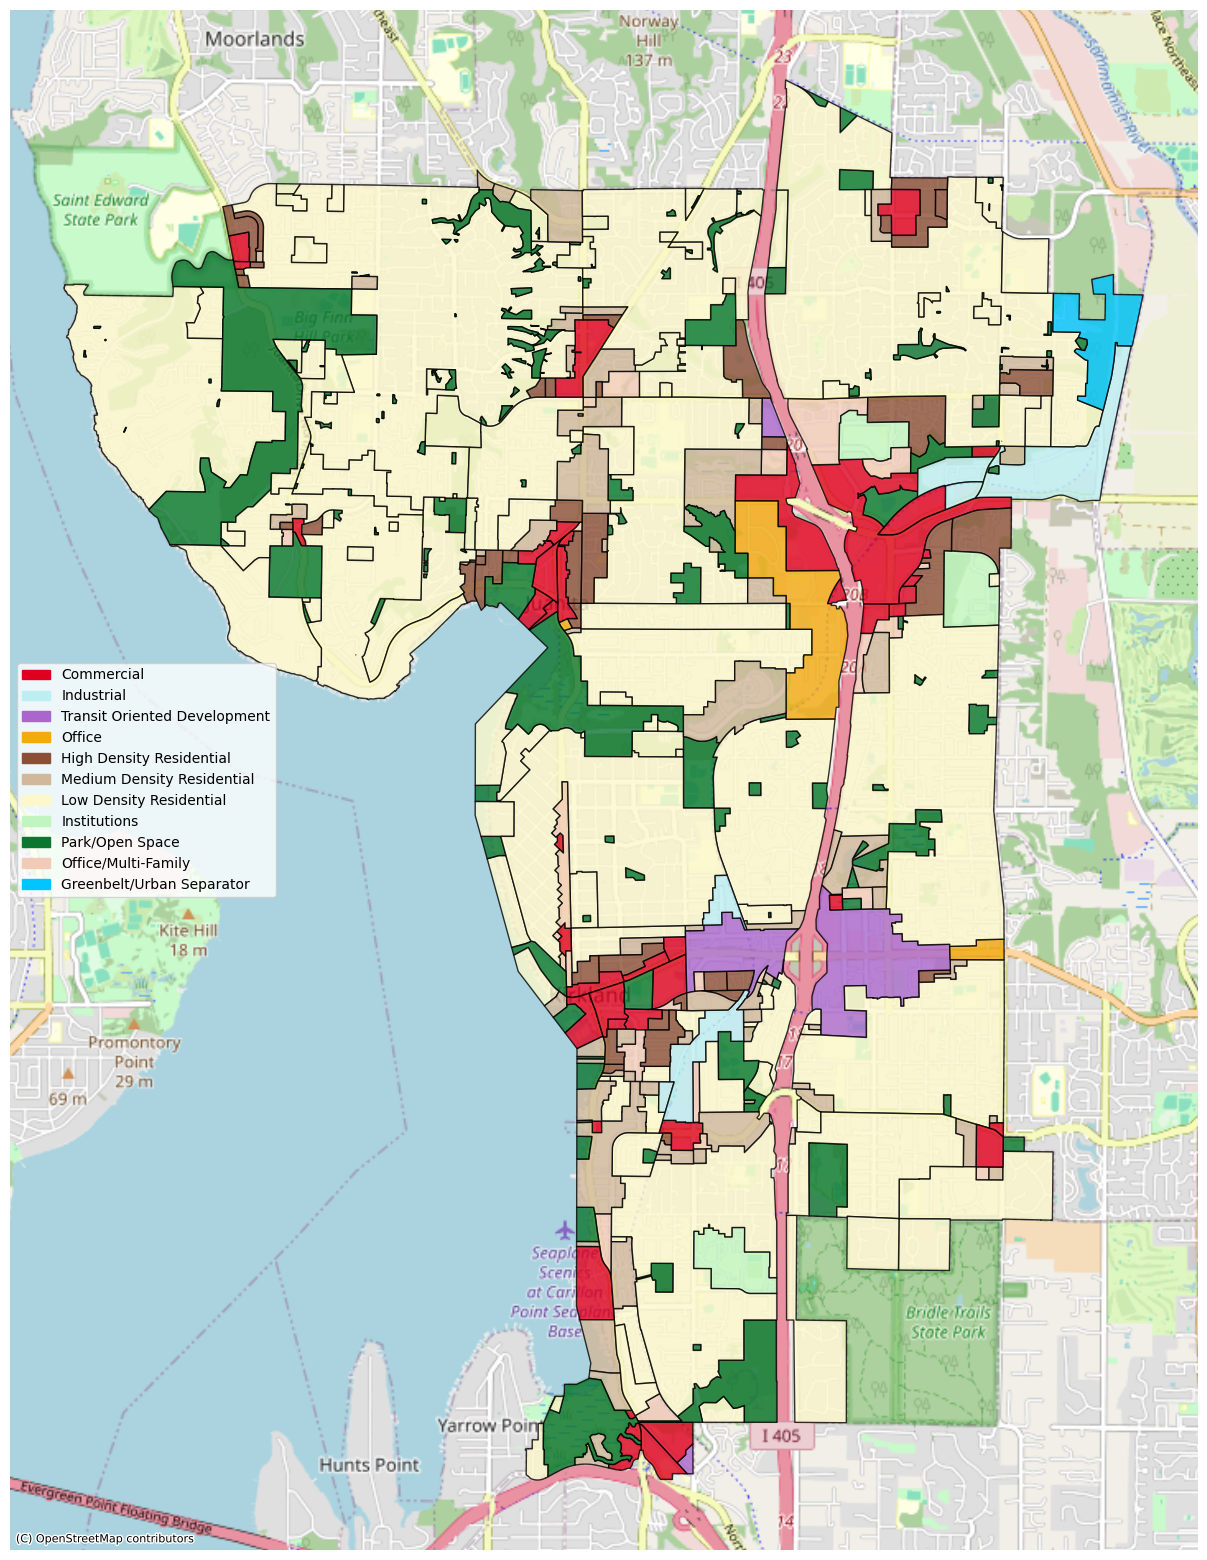

In [22]:
ax = gdf.plot(color=gdf["color"], figsize=(20, 20), alpha=0.8, edgecolor="black")
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
handles = []
for key in old_color_map.keys():
    handles.append(mpatches.Patch(color=old_color_map[key], label=key))
ax.legend(handles=handles, loc="center left")
ax.axis("off")

(-13610767.166407846, -13596968.58979357, 6046749.440158415, 6064651.080911842)

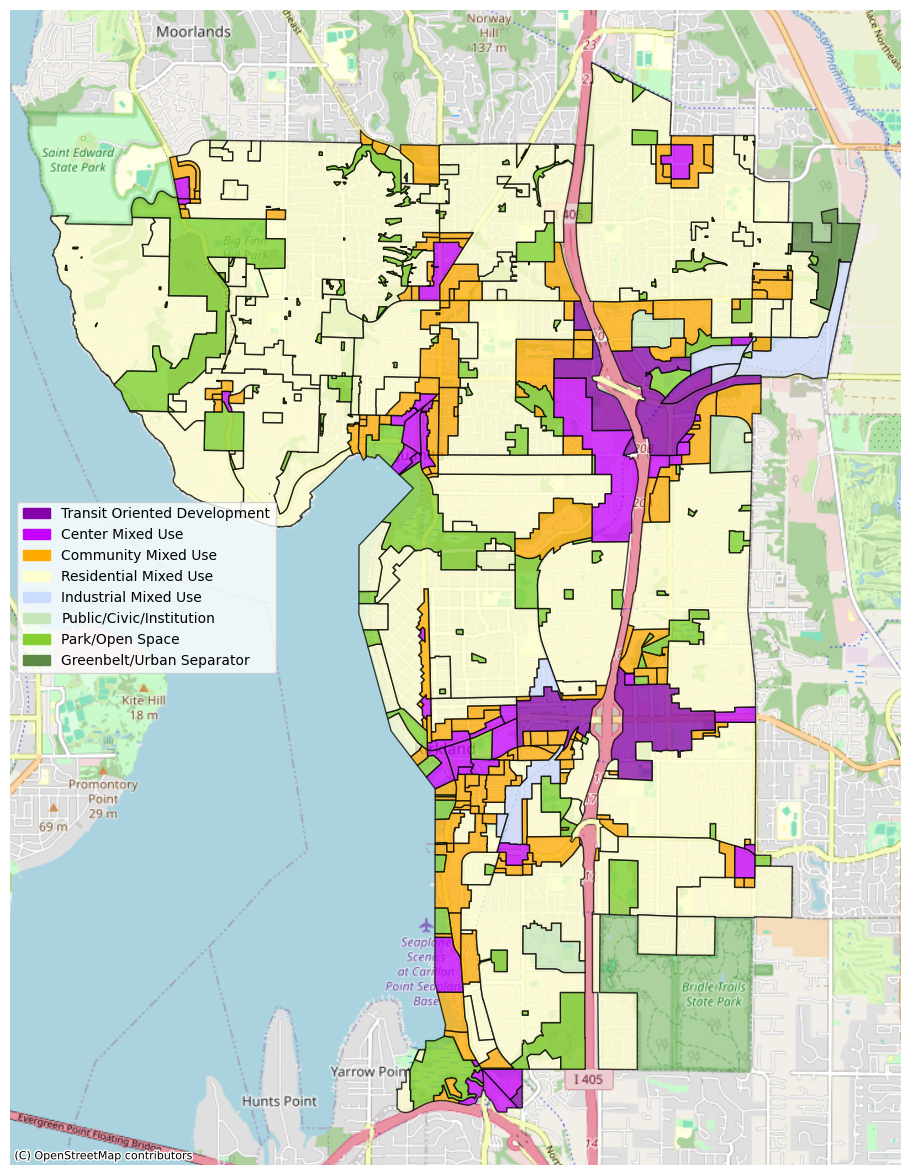

In [27]:
ax = gdf.plot(color=gdf["possible_new_color"], figsize=(15, 15), alpha=0.75, edgecolor="black")
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]
handles = []
for key in new_color_map.keys():
    handles.append(mpatches.Patch(color=new_color_map[key], label=key))
ax.legend(handles=handles, loc="center left")
# for _, r in gdf.iterrows():
#     plt.annotate(
#         text=r["index"],
#         xy=r["coords"],
#         horizontalalignment="center",
#     )
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

In [24]:
gdf.groupby(["COMP_DESN", "possible_new_category"]).sum(numeric_only=True)["area_acres"]

COMP_DESN                     possible_new_category       
Commercial                    Center Mixed Use                 352.519499
                              Community Mixed Use                1.631962
                              Transit Oriented Development     223.858851
Greenbelt/Urban Separator     Greenbelt/Urban Separator         79.311234
High Density Residential      Community Mixed Use              408.322261
Industrial                    Industrial Mixed Use             220.912231
Institutions                  Public/Civic/Institution         155.051789
Low Density Residential       Residential Mixed Use           7317.156721
Medium Density Residential    Community Mixed Use              710.999219
Office                        Center Mixed Use                 175.270013
                              Community Mixed Use                1.393867
Office/Multi-Family           Community Mixed Use              191.153720
Park/Open Space               Park/Open Space        

In [25]:
gdf.explore(color=gdf["possible_new_color"])